In [ ]:
### install mermake

In [ ]:
conda create -n mermake python=3.12
conda activate mermake
pip install mermake

In [ ]:
download&install cuda toolkit: https://developer.nvidia.com/cuda-12-8-0-download-archive

In [ ]:
pip install --pre cupy-cuda12x==14.0.0a1 -f https://pip.cupy.dev/pre

In [1]:
import glob
from dask import array as da
import os
import numpy as np
def read_im(path, return_pos=False):
    dirname = os.path.dirname(path)
    fov = os.path.basename(path).split('_')[-1].split('.')[0]
    file_ = os.path.join(dirname, fov, 'data')
    
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    if r'.fast.zarr' in txt:
        image = da.from_zarr(path)
        ncols = 5
        image = image.reshape([-1,ncols,image.shape[-2],image.shape[-1]])
        image = image.swapaxes(0,1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
            image = da.array([image[1]+image[2],image[3],image[4],image[0]])
    else:
        image = da.from_zarr(file_)[1:]
    
        shape = image.shape
        tag = '<z_offsets type="string">'
        zstack = txt.split(tag)[-1].split('</')[0]
    
        nchannels = int(zstack.split(':')[-1])
        nzs = (shape[0] // nchannels) * nchannels
        image = image[:nzs].reshape([shape[0] // nchannels, nchannels, shape[-2], shape[-1]])
        image = image.swapaxes(0, 1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
    
    if return_pos:
        return image, x, y
    return image
    
def get_pos(path):
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    return x,y

def get_im_from_Xh(Xh,resc=5):
    X = np.round(Xh[:,:3]/resc).astype(int)
    sz = np.max(X,axis=0)
    imf = np.zeros(sz+1,dtype=np.float32)
    imf[tuple(X.T)]=1
    return imf
from scipy.spatial import KDTree
def get_Xtzxy(X,X_ref,tzxy0,resc,target=3):
    tzxy = tzxy0
    Npts =0
    for dist_th in np.linspace(resc,target,5):
        XT = X-tzxy
        ds,inds = KDTree(X_ref).query(XT,workers=20)
        keep = ds<dist_th
        X_ref_ = X_ref[inds[keep]]
        X_ = X[keep]
        tzxy = np.mean(X_-X_ref_,axis=0)
        #print(tzxy)
        Npts = np.sum(keep)
    return tzxy,Npts
def get_best_translation_points(X,X_ref,resc=10,target=1,constr=None,return_counts=False):
    XFF = np.concatenate([X,X_ref])
    X = X-np.min(XFF,axis=0)
    X_ref = X_ref-np.min(XFF,axis=0)
    if constr is not None:
        Xm = np.max([np.min(X,axis=0),np.min(X_ref,axis=0)],axis=0)-constr
        XM = np.min([np.max(X,axis=0),np.max(X_ref,axis=0)],axis=0)+constr
        keep = np.all((X<=XM)&(X>=Xm),axis=-1)
        X = X[keep]
        keep = np.all((X_ref<=XM)&(X_ref>=Xm),axis=-1)
        X_ref = X_ref[keep]
        XFF = np.concatenate([X,X_ref])
        X = X-np.min(XFF,axis=0)
        X_ref = X_ref-np.min(XFF,axis=0)
    
    im = get_im_from_Xh(X,resc=resc)
    im_ref = get_im_from_Xh(X_ref,resc=resc)
    
    from scipy.signal import fftconvolve
    im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
    #plt.imshow(np.max(im_cor,0))
    tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1
    tzxy = tzxy*resc
    Npts=0
    tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc,target=target)
    if return_counts:
        return tzxy,Npts
    return tzxy
def calc_color_matrix(x,y,order=2):
    """This gives a quadratic color transformation (in matrix form)
    x is Nx3 vector of positions in the reference channel (typically cy5)
    y is the Nx3 vector of positions in another channel (i.e. cy7)
    return m_ a 3x7 matrix which when multipled with x,x**2,1 returns y-x
    This m_ is indended to be used with apply_colorcor
    """ 
    x_ = np.array(y)# ref zxy
    y_ = np.array(x)-x_# dif zxy
    # get a list of exponents
    exps = []
    for p in range(order+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    # construct A matrix
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    m_ = [np.linalg.lstsq(A, y_[:,iy])[0] for iy in range(len(x_[0]))]
    m_=np.array(m_)
    return m_
def apply_colorcor(x,m=None):
    """This applies chromatic abberation correction to order 2
    x is a Nx3 vector of positions (typically 750(-->647))
    m is a matrix computed by function calc_color_matrix
    y is the corrected vector in another channel"""
    if m is None:
        return x
    exps = []
    order_max=10
    for p in range(order_max+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    #find the order
    mx,my = m.shape
    order = int((my-1)/mx)
    assert(my<len(exps))
    x_ = np.array(x)
    # construct A matrix
    exps = exps[:my]
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    diff = [np.dot(A,m_) for m_ in m]
    return x_+np.array(diff).T
def apply_transf(X1,Trans,resc = (4,10,10)):
    X1R = (X1//resc).astype(int)
    for i in np.arange(len(Trans.shape)-1):
        X1R[:,i] = np.clip(X1R[:,i],0,Trans.shape[i]-1)
    return X1+Trans[tuple(X1R.T)]
def calc_trasnf(X2,X1,szM = (40,2800,2800),resc = (4,10,10)):
    Trans = np.zeros(list(np.array(szM)//resc)+[3])
    Neles = np.zeros(list(np.array(szM)//resc))
    X1R = (X1//resc).astype(int)
    for i in np.arange(len(Trans.shape)-1):
        X1R[:,i] = np.clip(X1R[:,i],0,Trans.shape[i]-1)
    np.add.at(Trans,tuple(X1R.T),X2-X1)
    np.add.at(Neles,tuple(X1R.T),1)
    TransF = Trans/Neles[...,np.newaxis]
    
    Xbad = np.array(np.where(np.isnan(TransF[...,0]))).T
    Xgood= np.array(np.where(~np.isnan(TransF[...,0]))).T
    dd,ii = KDTree(Xgood).query(Xbad)
    TransF[tuple(Xbad.T)]=TransF[tuple(Xgood[ii].T)]
    return TransF

In [60]:
fls = np.sort(glob.glob(r'Z:\MERFISHp\12_16_2025_BigSlideTest\DriftCor\R1_MER_set1\*.zarr'))
pos = np.array([get_pos(fl) for fl in fls])
fovs = [os.path.basename(fl).replace('.zarr','') for fl in fls]
sz = 2800
pix_size=0.108333
posT = np.array([get_pos(fl.replace('R1_MER','R2_MER')) for fl in fls])



In [707]:
fovT

'Conv_zscan1__044'

In [95]:
def load_fov1(fov):
    Xh = np.load(rf'Z:\MERFISHp\12_16_2025_BigSlideTest\DriftCor\mermake_fits\{fov}--R1_MER_set1--col1__Xhfits.npz')['Xh']
    Xh_ = Xh[Xh[:,-4]>0.5]
    X = Xh_[:,:3]
    return X
def load_fov2(fov):
    Xh = np.load(rf'Z:\MERFISHp\12_16_2025_BigSlideTest\DriftCor\mermake_fits\{fov}--R2_MER_set1--col1__Xhfits.npz')['Xh']
    Xh_ = Xh[Xh[:,-4]>0.5]
    X = Xh_[:,:3]
    return X
def rechunk(x1,x2,resc= (10,50,50)):
    x1r = np.array(x1//resc).astype(int)
    dic1={}
    dic2={}
    for ix in np.arange(len(x1r)):
        key = tuple(x1r[ix])
        if key not in dic1: dic1[key]=[]
        if key not in dic2: dic2[key]=[]
        dic1[key].append(x1[ix])
        dic2[key].append(x2[ix])
    x1_ = []
    x2_ = []
    for key in dic1:
        x1_.append(np.mean(dic1[key],axis=0))
        x2_.append(np.mean(dic2[key],axis=0))
    x1_ = np.array(x1_)
    x2_ = np.array(x2_)
    return x1_,x2_

In [222]:
ifovT = 42#45,42,17,27,35,16,22,53,67
fovT = fovs[ifovT]
pT = posT[ifovT]
ifovs1 = np.where(np.all(np.abs((pos-pT)/pix_size)<sz*1.25,axis=-1))[0]
XT = load_fov2(fovT)
XT0=XT.copy()
XsO = []
for ifov in ifovs1:
    X = load_fov1(fovs[ifov])
    XsO.append(X)

from tqdm import tqdm
for ie in tqdm(np.arange(20)):
    Xs = []
    for ie,ifov in enumerate(ifovs1):
        X = XsO[ie]
        px,py = (pos[ifov]-pT)/pix_size
        X1 = X.copy()+[0,px,py]
        tzxy = get_best_translation_points(X1.copy(),XT.copy(),resc=5,target=3,constr=150,return_counts=False)
        X1 = X1-tzxy
        Xs.append(X1)
    if False:
        V = napari.Viewer()
        V.add_points(XT[:,1:],face_color=np.random.random(3),size=5)
        for X in Xs:
            V.add_points(X[:,1:],face_color=np.random.random(3),size=5)
    XsT = list(Xs)
    Xs = np.concatenate(Xs)
    dd,ii = KDTree(Xs).query(XT)
    Xfix = Xs[ii]
    dth = np.linspace(100,5,20)[ie]
    keep = dd<dth
    
    #TransF = calc_trasnf(Xfix,XT,szM = (40,2800,2800),resc = (4,10,10))
    #XT = apply_transf(XT,TransF,resc = (4,10,10))
    
    x1,x2 = Xfix[keep],XT[keep]
    x1_,x2_ = x1,x2
    #x1_,x2_ = rechunk(x1,x2,resc= (100,100,100))
    m = calc_color_matrix(x1_,x2_,order=4)
    XT = apply_colorcor(XT,m)
    for i in range(len(XsO)):
        XsO[i] = apply_colorcor(XsO[i],m)
        #XsO[i] = apply_transf(XsO[i],TransF,resc = (4,10,10))

        
#XT0 = load_fov2(fovT)
#mF = calc_color_matrix(XT,XT0,order=4)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.34it/s]


(array([ 509., 2248., 4404., 5757., 5896., 5441., 4696., 3989., 3437.,
        2868.]),
 array([0.02287974, 1.02057679, 2.01827383, 3.01597088, 4.01366793,
        5.01136498, 6.00906202, 7.00675907, 8.00445612, 9.00215317,
        9.99985021]),
 <BarContainer object of 10 artists>)

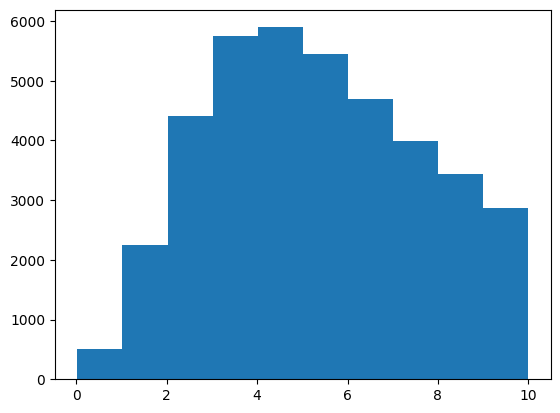

In [223]:
dd,ii = KDTree(XsO[0]).query(XsO[1])
import matplotlib.pylab as plt
plt.hist(dd[dd<10])

In [224]:
import napari
V = napari.Viewer()
V.add_points(XT[:,1:],face_color='m',size=2,blending='Additive',border_width=0)
count = 0
cols = ['r','g','b','c']
for X in XsT:
    V.add_points(X[:,1:],face_color=cols[count],size=2,blending='Additive',border_width=0)
    count+=1

In [225]:
#Xpair1 = []
#Xpair2 = []
Xpair1.append(XT)
Xpair2.append(XT0)

In [228]:
MM = calc_trasnf(Xpair1_, Xpair2_)
Xpair2T = apply_transf(Xpair2_,MM)

C:\Users\miket\AppData\Local\Temp\ipykernel_21752\3705701192.py:161: RuntimeWarning: invalid value encountered in divide
  TransF = Trans/Neles[...,np.newaxis]


In [229]:
Xpair1_ = np.concatenate(Xpair1)
Xpair2_ = np.concatenate(Xpair2)
V = napari.Viewer()
V.add_points(Xpair1_[:,1:],face_color='r',size=2,blending='Additive',name='XT0')
#V.add_points(XT0f[:,1:],face_color='g',size=5,blending='Additive',name='XT0f')
V.add_points(Xpair2_[:,1:],face_color='g',size=2,blending='Additive',name='XT')
V.add_points(Xpair2T[:,1:],face_color='c',size=2,blending='Additive',name='XT2')


<Points layer 'XT2' at 0x1cdfee89ea0>

In [209]:
XT0 = load_fov2(fovT)
V = napari.Viewer()
V.add_points(XT0[:,1:],face_color='r',size=2,blending='Additive',name='XT0')
#V.add_points(XT0f[:,1:],face_color='g',size=5,blending='Additive',name='XT0f')
V.add_points(XT[:,1:],face_color='g',size=2,blending='Additive',name='XT')

<Points layer 'XT' at 0x1cddb59ae60>

C:\Users\miket\AppData\Local\Temp\ipykernel_23036\1955705307.py:14: RuntimeWarning: invalid value encountered in divide
  TransF = Trans/Neles[...,np.newaxis]


In [210]:
# XT0 = load_fov2(fovT)
# V = napari.view_points(XT[:,1:],border_width=0,face_color='r',blending='Additive')
# V.add_points(XT0[:,1:],border_width=0,face_color='g',blending='Additive')

In [245]:
Xpair1_ = np.concatenate(Xpair1)
Xpair2_ = np.concatenate(Xpair2)
#MM = calc_trasnf(Xpair1_, Xpair2_,resc=(10, 50, 50))
MM = calc_color_matrix(Xpair1_, Xpair2_,order=4)
Xpair2T = apply_colorcor(Xpair2_,MM)
V=napari.Viewer()
V.add_points(Xpair1_[:,1:],face_color='r',size=2,blending='Additive',name='XT0')
#V.add_points(XT0f[:,1:],face_color='g',size=5,blending='Additive',name='XT0f')
V.add_points(Xpair2_[:,1:],face_color='g',size=2,blending='Additive',name='XT')
V.add_points(Xpair2T[:,1:],face_color='c',size=2,blending='Additive',name='XT2')


<Points layer 'XT2' at 0x1cdd7aa9f30>

In [849]:
A_save=A.copy()

In [829]:
A = A_save.copy()

In [503]:
### we want X1+f(X1)+T = X2+f(X2)   where X1 and X2 are before distortion, T is drift, f is distortion function

In [853]:
#for iiter  in tqdm(np.arange(7)):
def get_Xtilda(x_,order=4):
    exps = []
    for p in range(order+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    # construct A matrix
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    return A

XTil,bT = [],[]
order=4
dth=2.5
for ifovT in [44,22,17,19,21,23,24,26]:#[22,20,17,19,30,35,21,23,24,26,44]:
    fovT = fovs[ifovT]
    pT = posT[ifovT]
    ifovs1 = np.where(np.all(np.abs((pos-pT)/pix_size)<sz*1.25,axis=-1))[0]
    
    XT0 = load_fov2(fovT)
    XT0N = XT0.copy()
    #XT0 = apply_colorcor(XT0,MM)
    #XT0[:,1:] = (XT0+get_Xtilda(XT0,order=order)@A)[:,1:]
    #XT0[:,0] = (XT0[:,0]+(XT0+get_Xtilda(XT0,order=order)@A)[:,0])/2
    XT0 = (XT0+get_Xtilda(XT0,order=order)@A)
    
    XsO0 = []
    Xs1s = []
    for ifov in ifovs1:
        X = load_fov1(fovs[ifov])
        Xs1s.append(X.copy())
        #X = apply_colorcor(X,mF)
        #X = apply_transf(X,MM)
        #X = apply_colorcor(X,MM)
        #X[:,1:] = (X+get_Xtilda(X,order=order)@A)[:,1:]
        #X[:,0] = (X[:,0]+(X+get_Xtilda(X,order=order)@A)[:,0])/2
        X = (X+get_Xtilda(X,order=order)@A)
        XsO0.append(X)
    Xs = []
    Ts = []
    for ie,ifov in enumerate(ifovs1):
        X = XsO0[ie]
        px,py = (pos[ifov]-pT)/pix_size
        X1 = X.copy()+[0,px,py]
        tzxy = get_best_translation_points(X1,XT0,resc=5,target=3,constr=150,return_counts=False)
        X1 = X1-tzxy
        Xs.append(X1)
        Ts.append([0,px,py]-tzxy)
    if False:
        import napari
        V = napari.Viewer()
        V.add_points(XT0[:,1:],face_color='m',size=2,blending='Additive',border_width=0)
        count = 0
        cols = ['r','g','b','c']
        for X in Xs:
            V.add_points(X[:,1:],face_color=cols[count],size=2,blending='Additive',border_width=0)
            count+=1
            
    
    
    for ie in np.arange(len(Xs)):
        
        X1c = Xs1s[ie]# X1 before distortion
        X2c = XT0N
        T = Ts[ie]
    
        X1F = Xs[ie]
        X2F = XT0
        dd,ii = KDTree(X1F).query(X2F)
        keep = dd<dth
        X1,X2 = X1c[ii[keep]],X2c[keep]
        X1tilda = get_Xtilda(X1,order=order)
        X2tilda = get_Xtilda(X2,order=order)
        Xtilda_dif = X1tilda-X2tilda
        b = X2-X1-T
        XTil.append(Xtilda_dif)
        bT.append(b)
    import itertools
    if True:
        for ie1,ie2 in list(itertools.combinations(np.arange(len(Xs)),2)):
            
            X1c = Xs1s[ie1]# X1 before distortion
            X2c = Xs1s[ie2]# X2 before distortion
        
            T1 = Ts[ie1]
            T2 = Ts[ie2]
        
            X1F = Xs[ie1]
            X2F = Xs[ie2]
            dd,ii = KDTree(X1F).query(X2F)
            keep = dd<dth
            X1,X2 = X1c[ii[keep]],X2c[keep]
            
            X1tilda = get_Xtilda(X1,order=order)
            X2tilda = get_Xtilda(X2,order=order)
            Xtilda_dif = X1tilda-X2tilda
            b = X2+T2-X1-T1
            XTil.append(Xtilda_dif)
            bT.append(b)

XTil = np.concatenate(XTil)
bT = np.concatenate(bT)
A = np.linalg.lstsq(XTil,bT)[0]
A[0,:] = 0

In [855]:
Xtc = []
for z in np.linspace(0,40-1,20):
    for x in np.linspace(0,2800-1,200):
        for y in np.linspace(0,2800-1,200):
            Xtc.append([z,x,y])
Xtc = np.array(Xtc)
Xtt = Xtc+get_Xtilda(Xtc,order=4)@A
V = napari.Viewer()
V.add_points(Xtc[:,1:],face_color='r',border_width=0,size=1)
V.add_points(Xtt[:,1:],face_color='g',border_width=0,size=1)

<Points layer 'Points [1]' at 0x1d3fdd3c220>

In [775]:
#plt.hist(Xtt[:,0].ravel(),bins=100)

In [776]:
# dif = X1+get_Xtilda(X1,order=order)@A+T1-(X2+get_Xtilda(X2,order=order)@A+T2)
# np.median(np.abs(dif),axis=0)

In [852]:
XT0 = load_fov2(fovT)
XT0N = XT0.copy()
XT0 = XT0+get_Xtilda(XT0,order=order)@A

XsO0 = []
Xs1s = []
for ifov in ifovs1:
    X = load_fov1(fovs[ifov])
    Xs1s.append(X.copy())
    #X = apply_colorcor(X,mF)
    #X = apply_transf(X,MM)
    #X = apply_colorcor(X,MM)
    X = X+get_Xtilda(X,order=order)@A
    XsO0.append(X)
Xs = []
Ts = []
for ie,ifov in enumerate(ifovs1):
    X = XsO0[ie]
    px,py = (pos[ifov]-pT)/pix_size
    X1 = X.copy()+[0,px,py]
    tzxy = get_best_translation_points(X1,XT0,resc=5,target=3,constr=150,return_counts=False)
    X1 = X1-tzxy
    Xs.append(X1)
    Ts.append([0,px,py]-tzxy)
if True:
    import napari
    V = napari.Viewer()
    V.add_points(XT0[:,1:],face_color='m',size=3,blending='Additive',border_width=0)
    count = 0
    cols = ['r','g','b','c']
    for X in Xs:
        V.add_points(X[:,1:],face_color=cols[count],size=3,blending='Additive',border_width=0)
        count+=1

In [709]:
#A

In [713]:
np.max(X1c,axis=0)

array([  39.00002, 2796.1965 , 2797.1177 ], dtype=float32)

In [857]:
Xtc = []
for z in np.linspace(0,40-1,20):
    for x in np.linspace(0,2800-1,200):
        for y in np.linspace(0,2800-1,200):
            Xtc.append([z,x,y])
Xtc = np.array(Xtc)

In [858]:
Xtc = np.round(Xtc)#.astype(int)

In [859]:
MA = calc_color_matrix(Xtc+get_Xtilda(Xtc,order=order)@A,Xtc,order=4)

In [864]:
np.save(r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy',MA)

In [860]:
Xtt = apply_colorcor(Xtc,MA)

In [863]:
np.max(np.abs(Xtt - (Xtc+get_Xtilda(Xtc,order=4)@A)))

np.float64(0.00043542681955199836)

In [739]:
Xtt = Xtc+get_Xtilda(Xtc,order=4)@A

In [741]:
Xtt = apply_colorcor(Xtc,mF)

In [742]:
Xtc = []
for z in np.linspace(0,40-1,20):
    for x in np.linspace(0,2800-1,200):
        for y in np.linspace(0,2800-1,200):
            Xtc.append([z,x,y])
Xtc = np.array(Xtc)
Xtt = Xtc+get_Xtilda(Xtc,order=4)@A
V = napari.Viewer()
V.add_points(Xtc,face_color='r',border_width=0)
V.add_points(Xtt,face_color='g',border_width=0)

<Points layer 'Xtt' at 0x1ced18e2e90>

In [735]:
#np.max(Xtc,axis=0).astype(int)+1

In [728]:
#MA = calc_color_matrix(X1c+get_Xtilda(X1c,order=order)@A,X1c,order=4)

In [729]:
np.max(np.abs(apply_colorcor(Xtc,MA)-(Xtc+get_Xtilda(Xtc,order=order)@A)))

np.float64(0.002481759146260032)

In [536]:
#np.save(r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformOld.npy',MM)

In [730]:
np.save(r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy',MA)

In [538]:
XT0 = load_fov2(fovT)
XT0N = XT0.copy()
#XT0 = XT0+get_Xtilda(XT0,order=order)@A
XT0 = apply_colorcor(XT0,MA)
XsO0 = []
Xs1s = []
for ifov in ifovs1:
    X = load_fov1(fovs[ifov])
    Xs1s.append(X.copy())
    #X = apply_colorcor(X,mF)
    #X = apply_transf(X,MM)
    X = apply_colorcor(X,MA)
    #X = X+get_Xtilda(X,order=order)@A
    XsO0.append(X)
Xs = []
Ts = []
for ie,ifov in enumerate(ifovs1):
    X = XsO0[ie]
    px,py = (pos[ifov]-pT)/pix_size
    X1 = X.copy()+[0,px,py]
    tzxy = get_best_translation_points(X1,XT0,resc=5,target=3,constr=150,return_counts=False)
    X1 = X1-tzxy
    Xs.append(X1)
    Ts.append([0,px,py]-tzxy)
if True:
    import napari
    V = napari.Viewer()
    V.add_points(XT0[:,1:],face_color='m',size=2,blending='Additive',border_width=0)
    count = 0
    cols = ['r','g','b','c']
    for X in Xs:
        V.add_points(X[:,1:],face_color=cols[count],size=2,blending='Additive',border_width=0)
        count+=1

In [445]:
import napari
V = napari.Viewer()
V.add_points(X1c[:,1:],face_color='r',size=2,blending='Additive',border_width=0)
V.add_points((X1c+get_Xtilda(X1c,order=order)@A)[:,1:],face_color='g',size=2,blending='Additive',border_width=0)

<Points layer 'Points [1]' at 0x1ce64e68460>

In [543]:
#plt.loglog(A.ravel(),MA.ravel(),'o')

In [548]:
sz

2800

In [663]:
pos
fovs
ifov = 35
dists_pix = np.linalg.norm(np.abs((pos[ifov]-pos)/pix_size),axis=-1)
allneigh = np.where(dists_pix<np.sqrt(2)*sz*1.25)[0]
allneigh = allneigh[np.argsort(dists_pix[allneigh])]

In [702]:

def load_fov(fov):
    Xh = np.load(rf'Z:\MERFISHp\12_16_2025_BigSlideTest\DriftCor\mermake_fits\{fov}--R1_MER_set1--col1__Xhfits.npz')['Xh']
    return Xh

Xhs,Xprev,posT_fovs= [],[],[]
tfov=0

for ifv in tqdm(allneigh):
    Xh = load_fov(fovs[ifv])
    Xh = Xh[Xh[:,-2]>0.25]
    Xh[:,3] = tfov
    X = Xh[:,:3]
    X = apply_colorcor(X,MA)
    Xh[:,:3]=X
    X = X[Xh[:,-4]>0.5]

    pT = pos[allneigh[0]]
    px,py = (pos[ifv]-pT)/pix_size
    X = X+[0,px,py]
    if len(Xprev)>0:
        Xall = np.concatenate(Xprev)
        tzxy = np.array([0,0,0])
        try:
            tzxy = get_best_translation_points(X,Xall,resc=5,target=3,constr=50,return_counts=False)
            X = X-tzxy
        
        except:
            pass
    T = [0,px,py]-tzxy
    Xh[:,:3]+=T
    Xprev.append(X)
    Xhs.append(Xh)
    posT_fovs.append(T+np.array([40,sz,sz])/2)
    tfov+=1
Xhs = np.concatenate(Xhs)
XA = Xhs[:,:3]
iFOV = Xhs[:,3].astype(int)
dd,ii = KDTree(posT_fovs).query(XA,p=np.inf,workers=20)
XhsF = Xhs[ii==iFOV]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.51it/s]


In [706]:
V = napari.Viewer()
XA = Xhs[:,:3]
iFOV = Xhs[:,3].astype(int)
cols = np.array([np.random.random(3) for _ in np.arange(np.max(np.unique(iFOV)+1))])[iFOV]
XhsF = XhsF[XhsF[:,-4]>0.25]
V.add_points(XhsF[:,1:3],size=1,face_color=[1,1,1,0.01],border_width=0)

<Points layer 'Points' at 0x1cf50d0ef80>

In [672]:
iFOV

array([1, 1, 1, ..., 8, 8, 8], shape=(2424184,))

In [637]:
V = napari.Viewer()
for X in Xprev:
    col= np.random.random(3)
    col=col/np.max(col)
    V.add_points(X[:,1:],face_color=col,size=2,border_width=0)

In [280]:
?np.linalg.lstsq

Signature:       np.linalg.lstsq(a, b, rcond=None)
Call signature:  np.linalg.lstsq(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function lstsq at 0x000001CC419992D0>
File:            c:\users\miket\.conda\envs\merfishplus\lib\site-packages\numpy\linalg\_linalg.py
Docstring:      
Return the least-squares solution to a linear matrix equation.

Computes the vector `x` that approximately solves the equation
``a @ x = b``. The equation may be under-, well-, or over-determined
(i.e., the number of linearly independent rows of `a` can be less than,
equal to, or greater than its number of linearly independent columns).
If `a` is square and of full rank, then `x` (but for round-off error)
is the "exact" solution of the equation. Else, `x` minimizes the
Euclidean 2-norm :math:`||b - ax||`. If there are multiple minimizing
solutions, the one with the smallest 2-norm :math:`||x||` is returned.

Parameters
----------
a : (M, N) array_like
    "Coefficient" matrix.


In [ ]:
A@(X1tilda - X2tilda)=X2-X1-T
b = X2-

In [268]:
??calc_color_matrix

Signature: calc_color_matrix(x, y, order=2)
Source:   
def calc_color_matrix(x,y,order=2):
    """This gives a quadratic color transformation (in matrix form)
    x is Nx3 vector of positions in the reference channel (typically cy5)
    y is the Nx3 vector of positions in another channel (i.e. cy7)
    return m_ a 3x7 matrix which when multipled with x,x**2,1 returns y-x
    This m_ is indended to be used with apply_colorcor
    """ 
    x_ = np.array(y)# ref zxy
    y_ = np.array(x)-x_# dif zxy
    # get a list of exponents
    exps = []
    for p in range(order+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    # construct A matrix
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    m_ = [np.linalg.lstsq(A, y_[:,iy])[0] for iy in range(len(x_[0]))]
    m_=np.array(m_)
    return m_
File:      c:\

In [269]:
??np.linalg.lstsq

Signature:       np.linalg.lstsq(a, b, rcond=None)
Call signature:  np.linalg.lstsq(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function lstsq at 0x000001CC419992D0>
File:            c:\users\miket\.conda\envs\merfishplus\lib\site-packages\numpy\linalg\_linalg.py
Source:         
@array_function_dispatch(_lstsq_dispatcher)
def lstsq(a, b, rcond=None):
    r"""
    Return the least-squares solution to a linear matrix equation.

    Computes the vector `x` that approximately solves the equation
    ``a @ x = b``. The equation may be under-, well-, or over-determined
    (i.e., the number of linearly independent rows of `a` can be less than,
    equal to, or greater than its number of linearly independent columns).
    If `a` is square and of full rank, then `x` (but for round-off error)
    is the "exact" solution of the equation. Else, `x` minimizes the
    Euclidean 2-norm :math:`||b - ax||`. If there are multiple minimizing
    solutions, the one with 

In [250]:
np.save(r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1Transform.npy',MM)

In [235]:
napari.view_image(MM[...,1])

C:\Users\miket\AppData\Local\Temp\ipykernel_21752\3813241284.py:1: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  napari.view_image(MM[...,1])


Viewer(camera=Camera(center=(0.0, np.float64(139.5), np.float64(139.5)), zoom=np.float64(2.0357142857142856), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(4.0), 1.0, 0.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=3, ndisplay=2, order=(0, 1, 2), axis_labels=('0', '1', '2'), rollable=(True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(9.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(279.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(279.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0), point=(np.float64(4.0), np.float64(139.0), np.float64(139.0)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=F

In [233]:
MM.shape

(10, 280, 280, 3)

array([[  11.78295055,  184.81131798,  404.90687734],
       [  10.08651463,  371.74283653,  287.07631093],
       [   8.00877706,  409.40445763,  438.61122304],
       ...,
       [  27.52071309, 2724.52495444, 2772.63752588],
       [  27.48885655, 2599.00591147, 2753.57783349],
       [  26.67751622, 2633.26982749, 2677.33332666]], shape=(67210, 3))

In [24]:
fov = 'Conv_zscan1__050'


In [23]:

X = 
import napari
napari.view_points(X)

C:\Users\miket\AppData\Local\Temp\ipykernel_23036\1514224165.py:4: FutureWarning: `napari.view_points` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_points(...)` instead.
  napari.view_points(X)


Viewer(camera=Camera(center=(0.0, np.float64(1399.1225395202637), np.float64(1400.4605979919434)), zoom=np.float64(0.20305241723688763), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(1.0, 1.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(2.0524520874023438), stop=np.float64(2796.192626953125), step=np.float64(1.0)), RangeTuple(start=np.float64(1.8821334838867188), stop=np.float64(2799.0390625), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1399.0524520874023), np.float64(1399.8821334838867)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), layers=[<Points

array([ 0.2029565 ,  0.16359013, -0.07829005, ..., -0.06512374,
        0.14380991, -0.06959227], shape=(21622,), dtype=float32)

In [9]:
path = r'Z:\MERFISHp\12_16_2025_BigSlideTest\H10_MER_set10\Conv_zscan10__557.zarr'
im = read_im(path, return_pos=False)

In [10]:
import napari
napari.view_image(im)

C:\Users\miket\AppData\Local\Temp\ipykernel_23036\2259411468.py:2: FutureWarning: `napari.view_image` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_image(...)` instead.
  napari.view_image(im)


Viewer(camera=Camera(center=(0.0, np.float64(1399.5), np.float64(1399.5)), zoom=np.float64(0.20357142857142854), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(np.float64(1.0), np.float64(19.0), 0.0, 0.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=4, ndisplay=2, order=(0, 1, 2, 3), axis_labels=('0', '1', '2', '3'), rollable=(True, True, True, True), range=(RangeTuple(start=np.float64(0.0), stop=np.float64(3.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(39.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(2799.0), step=np.float64(1.0)), RangeTuple(start=np.float64(0.0), stop=np.float64(2799.0), step=np.float64(1.0))), margin_left=(0.0, 0.0, 0.0, 0.0), margin_right=(0.0, 0.0, 0.0, 0.0), p